In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

import matplotlib.colors as mcolors

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-01-03 07:57:55.201632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


In [2]:
experiment_dir = '/home/hpinkard_waller/models/Synthetic_Noise_v9/'

mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
phenotype_nlls = {}
phenotype_marker_indices = {}
for dir_name in os.listdir(experiment_dir):
    # check if complete.txt is in this directory
    if not os.path.exists(os.path.join(experiment_dir, dir_name, 'complete.txt')):
        # print('Skipping', dir_name)
        continue
    if 'Analysis' in dir_name:
        config_file_name = [d for d in os.listdir(os.path.join(experiment_dir, dir_name)) if '.yaml' in d][0]
        config_file_full_path = os.path.join(experiment_dir, dir_name, config_file_name)
        config = yaml.load(open(config_file_full_path, 'r'), Loader=yaml.FullLoader)
        photons_per_pixel = config['data']['synthetic_noise']['photons_per_pixel']
        channel = config['data']['channels'][0]
        replicate = config['metadata']['replicate']
        saving_dir = os.path.join(experiment_dir, dir_name)
        analysis_dir = os.path.join(saving_dir, 'analysis')
        mi_estimate_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'mi_estimates' in f][0]))
        mi_estimates_gp[(channel, photons_per_pixel, replicate)] = mi_estimate_file['mi_gp']


        mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)] = mi_estimate_file['mi_pixel_cnn']
        nll_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'phenotyping_nll' in f][0]))
        phenotype_nlls[(channel, photons_per_pixel, replicate)] = nll_file['nlls']
        phenotype_marker_indices[(channel, photons_per_pixel, replicate)] = nll_file['marker_indices']

        # print the channel, photons and mi_gp
        print(channel, photons_per_pixel, mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)])    

DPC_Right 150 0.17646054211336804
DPC_Right 450 0.2725657793925486
Brightfield 450 0.04964567581110667
Brightfield 50 0.027672699372690682
LED119 50 0.25262073723069073
Brightfield 450 0.048319522332793255
LED119 150 0.3546494326419865
LED119 150 0.3456078375576854
Brightfield 50 0.02906973205691382
Brightfield 150 0.05146548458583463
LED119 50 0.2570654093217842
LED119 50 0.25229463785911055
Brightfield 150 0.03307104581544805
DPC_Right 450 0.2769953864173949
LED119 150 0.34271542580398967
Brightfield 50 0.0294795191164389
DPC_Right 150 0.1784315426340796
LED119 450 0.4602983112428877
Brightfield 450 0.04917122241417976
LED119 50 0.25250795326447484
LED119 50 0.24968350438871426
LED119 150 0.34886796594921893
Brightfield 150 0.05027406737795328
DPC_Right 450 0.27821386540593956
LED119 150 0.34457981085671324
DPC_Right 150 0.1770917915235089
LED119 50 0.2501683294915321
LED119 50 0.25675889784307776
LED119 150 0.34118220090532625
LED119 150 0.3518552814162564
LED119 50 0.25321660441050

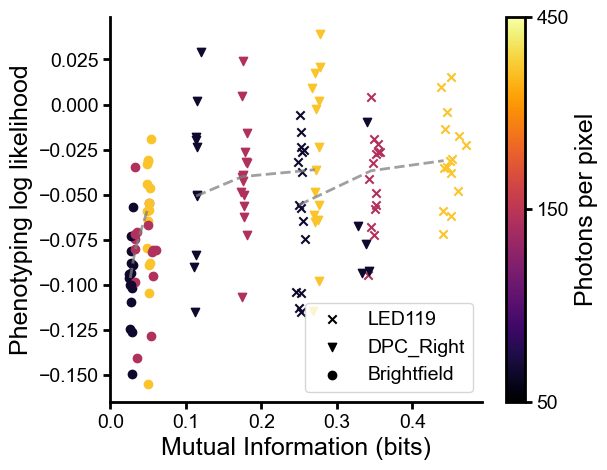

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# mi_estimates_to_use = mi_estimates_gp
mi_estimates_to_use = mi_estimates_pixel_cnn

color_indices =[20, 120, 220]

# iterate through all the tuples and make a scatter plot
for channel, photons_per_pixel, replicate in mi_estimates_to_use.keys():
    mi = mi_estimates_to_use[(channel, photons_per_pixel, replicate)]
    nlls = phenotype_nlls[(channel, photons_per_pixel, replicate)]
    marker_indices = phenotype_marker_indices[(channel, photons_per_pixel, replicate)]

    # pritn with 2 decimal format
    # print(channel, f'{photons_per_pixel}', '\t', f'{mi_gp:.2f}', f'{mi_pixel_cnn:.2f}', f'{nlls.mean():.2f}')

    if channel == 'LED119':
        marker = 'x'
    elif channel == 'DPC_Right':
        marker = 'v'
    elif channel == 'Brightfield':
        marker = 'o'

    # get inferno colormap from 0 to 1
    cmap = plt.get_cmap('inferno')

    if photons_per_pixel == 50:
        color = cmap(color_indices[0])
    elif photons_per_pixel == 150:
        color = cmap(color_indices[1])
    elif photons_per_pixel == 450:
        color = cmap(color_indices[2])

    ax.scatter(mi, -nlls.mean(), color=color, marker=marker)

# sort by channel and photons per pixel
channel_photons_results = {}
for (c, p, r) in mi_estimates_to_use.keys():
    if c not in channel_photons_results:
        channel_photons_results[c] = {}
    if p not in channel_photons_results[c]:
        channel_photons_results[c][p] = []
    mi = mi_estimates_to_use[(c, p, r)]
    nlls = phenotype_nlls[(c, p, r)]
    channel_photons_results[c][p].append((mi, nlls.mean()))

# plot the mean and std for each channel
for channel in channel_photons_results.keys():
    # take mean of each photon per pixel
    means_mi = []
    means_nll = []
    photons_per_pixel = sorted(channel_photons_results[channel].keys())
    for photons in photons_per_pixel:
        mi, nll = zip(*channel_photons_results[channel][photons])
        # means_mi.append(np.mean(mi))
        means_mi.append(np.percentile(mi, 20))
        # means_mi.append(np.median(mi))
        # means_nll.append(np.mean(nll))

        means_nll.append(np.median(nll))

    ax.plot(means_mi, -np.array(means_nll), '--', color='grey', alpha=0.75, linewidth=2)



ax.set_xlabel('Mutual Information (bits)')
ax.set_ylabel('Phenotyping log likelihood')
clear_spines(ax)
# legend
ax.scatter([], [], color='k', marker='x', label='LED119')
ax.scatter([], [], color='k', marker='v', label='DPC_Right')
ax.scatter([], [], color='k', marker='o', label='Brightfield')
ax.legend(loc='lower right', frameon=True)
ax.set_xlim([0, None])

cmap = plt.get_cmap('inferno')

# colorbar
# from matplotlib.colors import LogNorm
# norm = LogNorm(vmin=50, vmax=450)
# # Create a ScalarMappable and set the array
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# # Create the colorbar with specified ticks
# cbar = plt.colorbar(sm, ax=ax, ticks=[50, 150, 450])
# cbar.ax.set_yticklabels(['50', '150', '450'])

norm = mpl.colors.Normalize(vmin=20, vmax=220)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=color_indices)
# set tick labels
cbar.ax.set_yticklabels(['50', '150', '450'])


cbar.set_label('Photons per pixel')

# ax.set_ylim([-.15, None])

In [94]:
mcolors.Normalize(vmin=mi_center.min(), vmax=mi_center.max())

/tmp/ipykernel_34193/3674722194.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap('inferno')


(0.06134, 0.03659, 0.177642, 1.0)
(0.379001, 0.076253, 0.432719, 1.0)
(0.980032, 0.766837, 0.166353, 1.0)
(0.06134, 0.03659, 0.177642, 1.0)
(0.379001, 0.076253, 0.432719, 1.0)
(0.980032, 0.766837, 0.166353, 1.0)
(0.06134, 0.03659, 0.177642, 1.0)
(0.379001, 0.076253, 0.432719, 1.0)
(0.980032, 0.766837, 0.166353, 1.0)


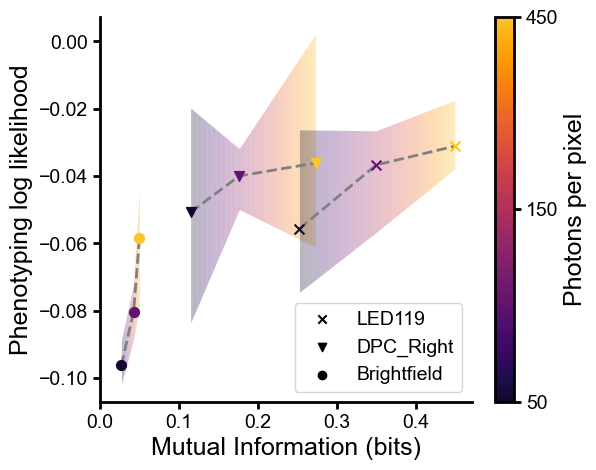

In [6]:


confidence_level = 0.9
color_indices =[20, 120, 220]
# colormap = plt.cm.inferno


# Choose a base colormap
base_colormap = plt.cm.get_cmap('inferno')

# Define the start and end points
start, end = min(color_indices) / 255, max(color_indices) / 255

from matplotlib.colors import LinearSegmentedColormap
# Create a new colormap from the portion of the original colormap
colormap = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=base_colormap.name, a=start, b=end),
    base_colormap(np.linspace(start, end, 256))
)

def marker_for_channel(channel):
    if channel == 'LED119':
        marker = 'x'
    elif channel == 'DPC_Right':
        marker = 'v'
    elif channel == 'Brightfield':
        marker = 'o'
    return marker


def color_for_photon_level(photons_per_pixel):
    # normalize the colormap
    min_photons_per_pixel =  min(list(zip(*mi_estimates_to_use.keys()))[1])
    max_photons_per_pixel =  max(list(zip(*mi_estimates_to_use.keys()))[1])

    return colormap((photons_per_pixel - min_photons_per_pixel) / (max_photons_per_pixel - min_photons_per_pixel) )


fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# mi_estimates_to_use = mi_estimates_gp
mi_estimates_to_use = mi_estimates_pixel_cnn


# iterate through all the tuples and make a scatter plot
for channel, photons_per_pixel, replicate in mi_estimates_to_use.keys():
    mi = mi_estimates_to_use[(channel, photons_per_pixel, replicate)]
    nlls = phenotype_nlls[(channel, photons_per_pixel, replicate)]
    marker_indices = phenotype_marker_indices[(channel, photons_per_pixel, replicate)]

    # single trial
    # ax.scatter(mi, -np.mean(nlls), color=color, marker=marker_for_channel(channel))

# sort by channel and photons per pixel
channel_photons_results = {}
for (c, p, r) in mi_estimates_to_use.keys():
    if c not in channel_photons_results:
        channel_photons_results[c] = {}
    if p not in channel_photons_results[c]:
        channel_photons_results[c][p] = []
    mi = mi_estimates_to_use[(c, p, r)]
    nlls = phenotype_nlls[(c, p, r)]
    channel_photons_results[c][p].append((mi, nlls.mean()))

# plot the mean and std for each channel
for channel in channel_photons_results.keys():
    # take mean of each photon per pixel
    mi_center = []
    mi_lower = []
    mi_upper = []

    nll_center = []
    nll_lower = []
    nll_upper = []
    photons_per_pixel = sorted(channel_photons_results[channel].keys())
    for photons in photons_per_pixel:
        mi, nll = zip(*channel_photons_results[channel][photons])
        
        # mi_center.append(np.percentile(mi, 20))
        mi_center.append(np.median(mi))

        # generate 1000 random resamples of mi
        # mi_resamples = []
        # for i in range(1000):
        #     mi_resamples.append(np.median(np.random.choice(mi, size=len(mi), replace=True)))
        # mi_resamples = np.array(mi_resamples)
        # mi_lower.append(np.percentile(mi_resamples, 100 - 100 * (1 + confidence_level) / 2))
        # mi_upper.append(np.percentile(mi_resamples, 100 * (1 + confidence_level) / 2))
       

        # generate 1000 random resamples of nll
        nll_resamples = []
        for i in range(1000):
            nll_resamples.append(np.median(np.random.choice(nll, size=len(nll), replace=True)))
        nll_resamples = np.array(nll_resamples)
        nll_center.append(np.median(nll))
        nll_lower.append(np.percentile(nll_resamples, 100 - 100 * (1 + confidence_level) / 2))
        nll_upper.append(np.percentile(nll_resamples, 100 * (1 + confidence_level) / 2))

        color = color_for_photon_level(photons)
        print(color)
        # median estimate marker
        ax.scatter(mi_center[-1], -nll_center[-1], color=color, marker=marker_for_channel(channel), s=50, zorder=100)
        # make a horizontal line for the error bar
        # ax.plot([mi_lower[-1], mi_upper[-1]], [-nll_center[-1], -nll_center[-1]], color=color, linewidth=2, zorder=100)

    mi_center = np.array(mi_center)
    nll_center = np.array(nll_center)
    nll_lower = np.array(nll_lower)
    nll_upper = np.array(nll_upper)
    
    # trendline for each contrast
    ax.plot(mi_center, -nll_center, '--', color='grey', alpha=1, linewidth=2)


   


    # cmap = plt.get_cmap('inferno')

    # norm = mpl.colors.Normalize(vmin=20, vmax=220)
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])
    # cbar = plt.colorbar(sm, ax=ax, ticks=color_indices)
    # # set tick labels
    # cbar.ax.set_yticklabels(['50', '150', '450'])

    # cbar.set_label('Photons per pixel')



    # error bars
    # linear interpolation of mi_center and nll_lower and nll_upper
    mi_upsampled = np.linspace(mi_center[0], mi_center[-1], 100)
    nll_lower_upsampled = np.interp(mi_upsampled, mi_center, nll_lower)
    nll_upper_upsampled = np.interp(mi_upsampled, mi_center, nll_upper)

    normalize = mcolors.Normalize(vmin=mi_center.min(), vmax=mi_center.max())

    for k in range(len(mi_upsampled) - 1):
        color = colormap(normalize(mi_upsampled[k]))

        ax.fill_between(mi_upsampled[k: k+2], 
                        -nll_lower_upsampled[k: k+2], -nll_upper_upsampled[k: k+2], 
                        color=color,
                     alpha=0.3,
                        linewidth=0, zorder=-100)



ax.set_xlabel('Mutual Information (bits)')
ax.set_ylabel('Phenotyping log likelihood')
clear_spines(ax)


# legend
ax.scatter([], [], color='k', marker='x', label='LED119')
ax.scatter([], [], color='k', marker='v', label='DPC_Right')
ax.scatter([], [], color='k', marker='o', label='Brightfield')
ax.legend(loc='lower right', frameon=True)
ax.set_xlim([0, None])


norm = mpl.colors.Normalize(vmin=min(color_indices), vmax=max(color_indices))
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=color_indices)
# set tick labels
cbar.ax.set_yticklabels(['50', '150', '450'])


cbar.set_label('Photons per pixel')

# ax.set_ylim([-.15, None])

# save as pdf
fig.savefig('/home/hpinkard_waller/figures/phenotyping/phenotyping_vs_mi.pdf', transparent=True)


Text(0.5, 1.0, 'Fill Between Plot with Color Gradient')

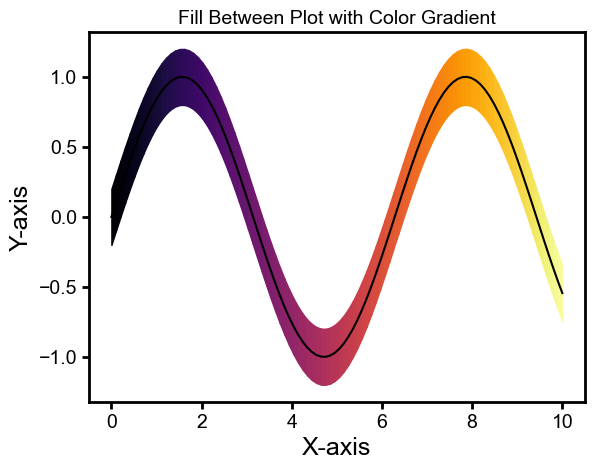

In [67]:


# Example data
x = np.linspace(0, 10, 100)
y = np.sin(x)
error = 0.2

# Upper and lower bounds for error
y1 = y - error
y2 = y + error

# Create a colormap
colormap = plt.cm.inferno
normalize = mcolors.Normalize(vmin=x.min(), vmax=x.max())

# Plot fill between with changing colors
for i in range(len(x) - 1):
    plt.fill_between(x[i:i+2], y1[i:i+2], y2[i:i+2], 
                     color=colormap(normalize(x[i])))

# Plot the central line
plt.plot(x, y, color='black')

# Add labels, title, etc.
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Fill Between Plot with Color Gradient')


In [3]:
markers, _, _, _, _ = get_targets_and_display_range(bsccm=bsccm, use_two_spectrum_unmixing=True)
markers

['CD45', 'CD123', 'CD19', 'CD56', 'CD14', 'CD16', 'HLA-DR', 'CD3']